In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/500
39/39 [==============================] - 9s 145ms/step - loss: 4.0759 - accuracy: 0.1260 - val_loss: 4.0166 - val_accuracy: 0.2210
Epoch 2/500
39/39 [==============================] - 5s 128ms/step - loss: 3.6660 - accuracy: 0.2157 - val_loss: 3.0552 - val_accuracy: 0.2210
Epoch 3/500
39/39 [==============================] - 5s 124ms/step - loss: 2.9891 - accuracy: 0.2044 - val_loss: 2.7564 - val_accuracy: 0.2210
Epoch 4/500
39/39 [==============================] - 5s 128ms/step - loss: 2.8498 - accuracy: 0.1948 - val_loss: 2.7024 - val_accuracy: 0.2210
Epoch 5/500
39/39 [==============================] - 5s 131ms/step - loss: 2.8108 - accuracy: 0.1945 - val_loss: 2.6845 - val_accuracy: 0.2210
Epoch 6/500
39/39 [==============================] - 5s 127ms/step - loss: 2.7959 - accuracy: 0.1874 - val_loss: 2.6691 - val_accuracy: 0.2210
Epoch 7/500
39/39 [==============================] - 5s 129ms/step - loss: 2.7899 - accuracy: 0.1851 - val_loss: 2.6608 - val_accuracy: 0.2210

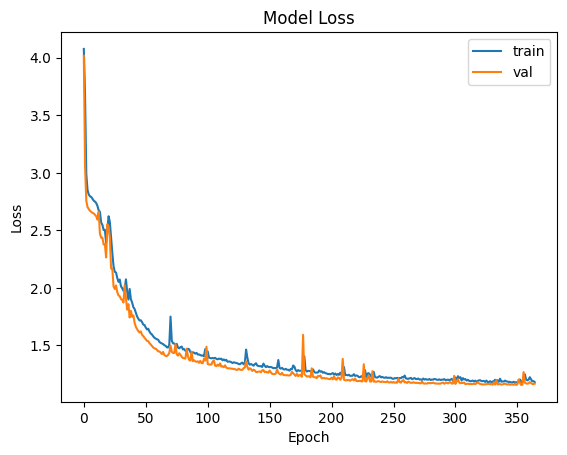

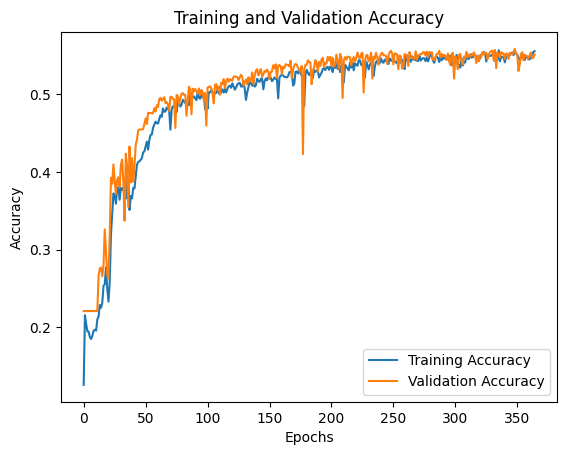

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input, Embedding, GlobalMaxPooling1D, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

stemmer = PorterStemmer()
train_df = pd.read_csv('/content/drive/MyDrive/346 project/training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1', usecols=['essay_id', 'essay_set', 'essay', 'domain1_score']).dropna(axis=1)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s.,\']', '', text)
    tokens = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords_set]
    return ' '.join(tokens)

def preprocess_text2(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s.,\']', '', text)
    tokens = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords_set]
    return tokens

def preprocess_text3(text):
    tokens = word_tokenize(text)
    return tokens

preprocess_data = lambda text: preprocess_text(text)
train_df["essay_prepro"] = train_df["essay"].apply(preprocess_data)
X = train_df.drop(["essay_id", "essay_set", "essay", "domain1_score"], axis=1)
X2 = train_df["essay_set"]
y = train_df["domain1_score"]
X2 = X2.astype(str)

tokenized_documents = [preprocess_text2(doc) for doc in X["essay_prepro"]]
tokenized_documents2 = [preprocess_text3(doc) for doc in X2]
combined_tokenized = []
for doc1, doc2 in zip(tokenized_documents, tokenized_documents2):
    combined_tokenized.append(doc1 + doc2)

ukuran_vektor = 100
word2vec_model = Word2Vec(sentences=combined_tokenized, min_count=1, vector_size=ukuran_vektor, sg=1)
all_words = word2vec_model.wv.index_to_key

max_length = train_df['essay_prepro'].apply(lambda x: len(x.split())).max()
max_length_index = train_df['essay_prepro'].apply(len).idxmax()
train_df.at[max_length_index, 'essay_prepro']

sequences = [[word2vec_model.wv.key_to_index[word] for word in text] for text in [preprocess_text2(doc) for doc in X['essay_prepro']]]
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

sequences2 = [[word2vec_model.wv.key_to_index[word] for word in text] for text in [preprocess_text3(doc) for doc in X2]]
padded_sequences2 = pad_sequences(sequences2, maxlen=max_length, padding='post')

y = np.asarray(y)
X_train, X_val, X_train2, X_val2, y_train, y_val = train_test_split(padded_sequences, padded_sequences2, y, test_size=0.25, random_state=92)

jumlah_kelas = 61
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, word2vec_model.vector_size))
for word, i in word2vec_model.wv.key_to_index.items():
    embedding_vector = word2vec_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

input1 = Input(shape=(max_length,))
input2 = Input(shape=(max_length,))

embedding_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], trainable=False)
embedded1 = embedding_layer(input1)
embedded2 = embedding_layer(input2)

lstm_out1 = LSTM(ukuran_vektor, return_sequences=True)(embedded1)
lstm_out2 = LSTM(ukuran_vektor, return_sequences=True)(embedded2)

max_pool1 = GlobalMaxPooling1D()(lstm_out1)
max_pool2 = GlobalMaxPooling1D()(lstm_out2)

concatenated = Concatenate()([max_pool1, max_pool2])
dense1 = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(dense1)
output = Dense(jumlah_kelas, activation='softmax')(dropout)

model = Model(inputs=[input1, input2], outputs=output)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit([X_train, X_train2], y_train, epochs=500, batch_size=256, validation_data=([X_val, X_val2], y_val), callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_val, X_val2], y_val, verbose=0)
print(f'loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
